In [14]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [15]:
def f(x):
    return 5*x**2 + 2*x + 3

In [16]:
f(5)

138

In [17]:
xs = np.arange(-10,10,step=0.5)
ys = f(xs)

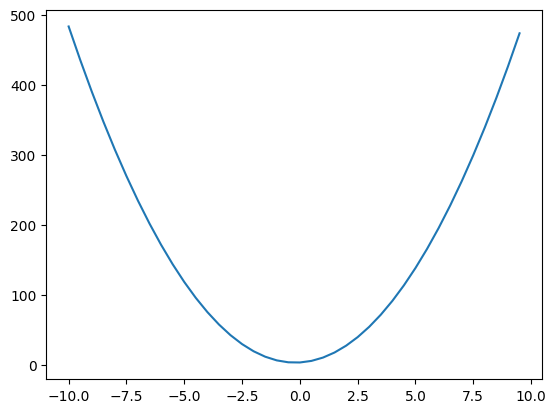

In [18]:
plt.plot(xs,ys)

In [62]:
class Value:

    def __init__(self, data, _children = (), _op='', label=''):
        self.data= data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        return f'Value({self.data})'
    
    def __add__(self, other):
        return Value(self.data + other.data, (self,other), '+')
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self,other), '-')
    
    def __mul__(self,other):
        return Value(self.data * other.data, (self,other), '*')
    
    def __truediv__(self, other):
        return Value(self.data/other.data, (self,other), '/')
    def tanh(self):
        x = self.data
        out = Value((math.exp(2*x)-1)/(math.exp(2*x)+1), label='output')
        return out
    
a = Value(2, label='a')
b = Value(5, label='b')
c = Value(8, label='c')
e = a*b; e.label='e'
d = e + c ; d.label = 'd'
f = Value(3, label='f')
L = d*f; L.label='L'

In [37]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{%s | data %.4f | %.4f}"% (n.label, n.data, n.grad ),
            shape='record'
        )

        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


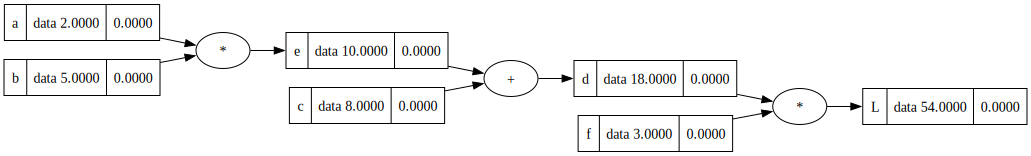

In [38]:
draw_dot(L)

# Chain Rule
L = d*f

dL/dd = f

dL/df = d

d = e + c

dd/dc = 1

dL/dc = dL/dd * dd/dc

dL/dc = f*1

In [39]:
L.grad = 1
f.grad = d.data
d.grad = f.data

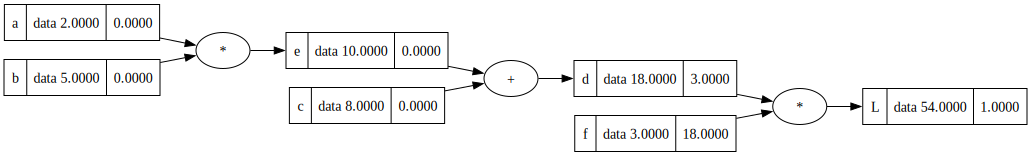

In [40]:
draw_dot(L)

In [41]:
e.grad = d.grad*1
c.grad = d.grad*1

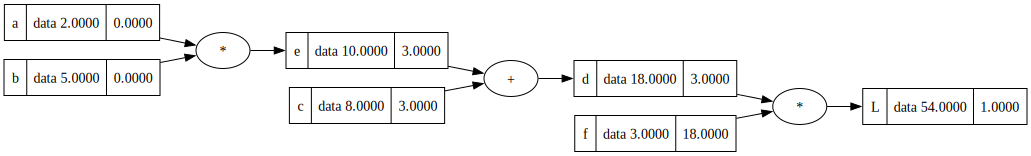

In [42]:
draw_dot(L)

In [43]:
a.grad = b.data*e.grad
b.grad = a.data*e.grad

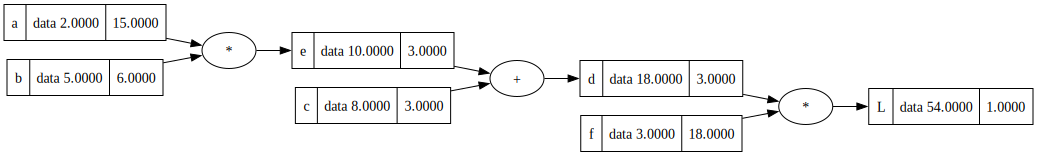

In [44]:
draw_dot(L)

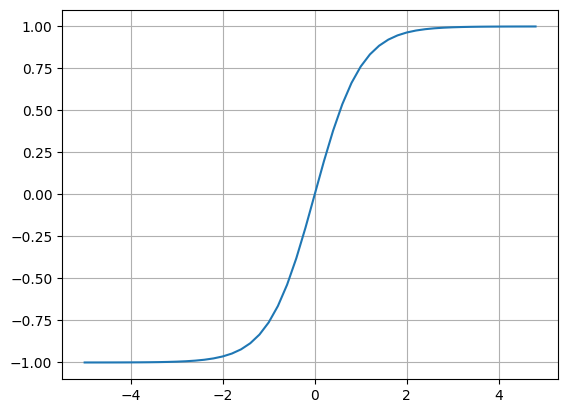

In [48]:
plt.plot(np.arange(-5,5,step=0.2), np.tanh(np.arange(-5,5,step=0.2))); plt.grid()

In [63]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.7,label='b')
x1w1 = x1*w1; x1w1.label='x1 * w1'
x2w2 = x2*w2; x2w2.label='x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label='n'
o = n.tanh()

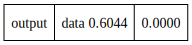

In [64]:
draw_dot(o)